# "Riddler Classic" 2020-10-23: absorbing Markov chains redux

This week's **[Riddler classic column](https://fivethirtyeight.com/features/can-you-feed-the-hot-hand/)** gives a timely basketball problem: 

> Now that LeBron James and Anthony Davis have restored the Los Angeles Lakers to glory with their recent victory in the NBA Finals, suppose they decide to play a game of sudden-death, one-on-one basketball. They’ll flip a coin to see which of them has first possession, and whoever makes the first basket wins the game.

> Both players have a 50 percent chance of making any shot they take. However, Davis is the superior rebounder and will always rebound any shot that either of them misses. Every time Davis rebounds the ball, he dribbles back to the three-point line before attempting another shot.

> Before each of Davis’s shot attempts, James has a probability p of stealing the ball and regaining possession before Davis can get the shot off. What value of p makes this an evenly matched game of one-on-one, so that both players have an equal chance of winning before the coin is flipped?

We can solve this problem using **[the same technique we used three weeks ago – absorbing Markov chains](https://github.com/khgiddon/misc/blob/main/riddler_2020_10_02_notebook.ipynb).** Thankfully the transition matrix for this problem is much simpler!

## Framework of state transitions

We can think about the problem as a transition between *states*. At any point, the basketball game is in a certain state, and this state determines the probabilities of transitioning to any other series of states. Each state is discrete. We can use the following diagram to represent the game, with each circle representing a state, and the annotated lines representing the probabilities of transition to each other state:

<img src="markov_files/riddler_2020_10_24_markov_1.png" align="center"/>

In the above *p* represents the probability of the steal. The game begins with a coin flip resulting in either a James possession or a Davis possession with equal probability (50%). Because Davis has no probability of stealing the ball, James shoots the ball on 100% of his possessions. Therefore we can skip modeling an explicit James possession state as separate from a James shooting state, and only create a state for James shooting. If James shoots, there is a 50% probability of him winning and a 50% probability of Davis getting the rebound.

For Davis, we need to separately model his possession state from his shooting state. If Davis gets the possession, James will steal with probability *(p)* and Davis will shoot with probability *(1-p)*. If Davis misses his shot, he will get his rebound, so the game will return the posession state where James gets another chance of a steal.

The states of James winning and Davis winning represent the game ending – these are known as the absorbing states because once they are reached they can never be left.

We can encode this transition diagram as a matrix (Python code below) and use this matrix to find the probability of ending in each of the absorbing states from the starting state (coin flip).

## Finding absorption probabilities from each starting state

We will use linear algebra to find a matrix $B$ that contains, for each state (not just the starting state), the probability of transitioning to each of the two absorbing states. The solution formula and proof is given in chapter 3 of [*Finite Markov Chains*](https://docs.ufpr.br/~lucambio/CE222/1S2014/Kemeny-Snell1976.pdf) by Kemeny and Snell (1960).

Given that:
- $Q$ represents a matrix containing the non-absorbing states of the full transition matrix
- $I$ is the [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix) of $Q$
- $R$ is a matrix containing rows for each of the non-absorbing states and columns for each of the absorbing states

$B$ = $(Q - I)^{-1} \times R$

Upon solving this equation we can find the probability of transitioning to each absorbing state from the initial state of the coin flip (i.e., the probability of James and Davis winning the game). By running the formula for each probability of steal from 0% to 100%, we can produce the following graph:

<img src="markov_files/riddler_2020_10_24_markov_2.png" align="center" width="400"/>

The graph seems to pass the eye-test. If James has no probability of stealing, his chance to win is 25%: he needs to win the coin flip and then make his first shot. If he misses the first shot, Davis gets the rebound and James can never get the ball back. Conversely, if James's probability of stealing is 100%, he wins all the time, because Davis can never shoot the ball – James wins it first!

Upon visual inspection of the graph, the lines seems to intersect at *p = 1/3*. We can run our formula with a starting value of *p = 1/3* to confirm that this is indeed the answer:

In [157]:
print(find_win_probabilities(p = 1/3))

(0.5, 0.5)


## Full code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [152]:
def find_win_probabilities(p):
    
    # Input p is probability of steal

    # Create transition matrix between each state
    M = np.array([
                   [0,1/2, 1/2,  0,  0,  0] # Coin flip
                  ,[0,  0, 1/2,  0,1/2,  0] # James shoots
                  ,[0,  p,   0,1-p,  0,  0] # Davis possesses
                  ,[0,  0, 1/2,  0,  0,1/2] # Davis shoots
                  ,[0,  0,   0,  0,  1,  0] # James wins
                  ,[0,  0,   0,  0,  0,  1] # Davis wins
                   ]) 

    # Find probability of absorption from each state
    I = np.eye(len(M) - 2)  
    Q = M[:-2, :-2]
    R = M[:-2,-2:]
    B = np.matmul(np.linalg.inv(I - Q), R)

    return round(B[0][0],5), round(B[0][1],5)
    
# Loop through probabilities of winning
result = [find_win_probabilities(p/100) for p in range(0,101)]

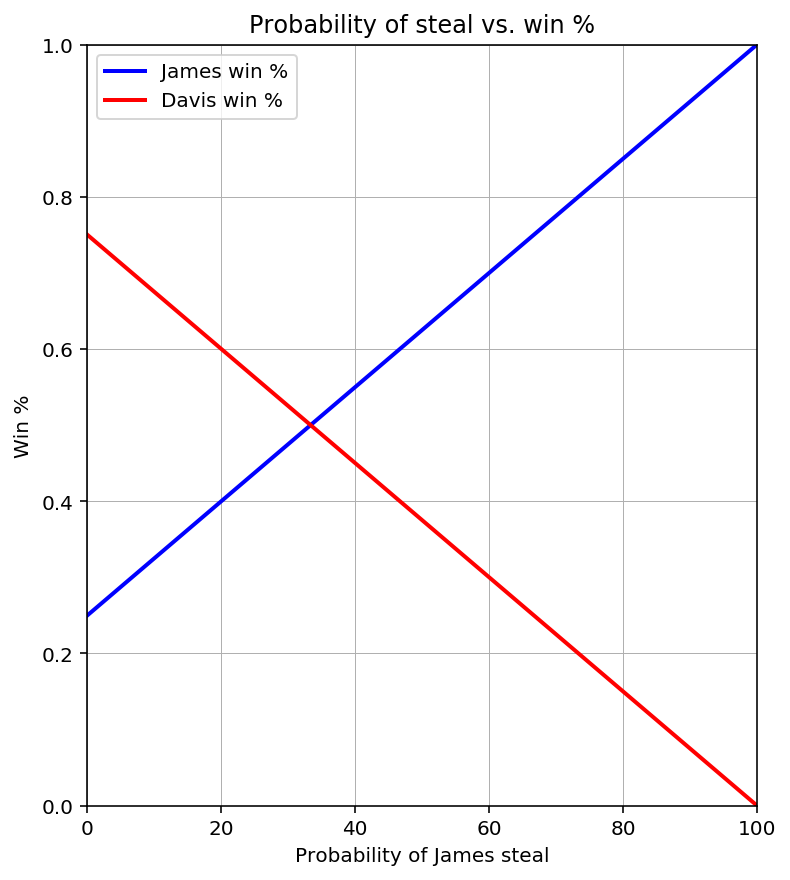

In [163]:
# Create graph
%config InlineBackend.figure_format = 'retina'

james = [i[0] for i in result]
davis = [i[1] for i in result]
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
plt.figure(figsize=(6, 7))      
  
# Plot
plt.ylim(0, 1)    
plt.xlim(0, 100)   
plt.plot(range(0,101),  james, lw=2, color="blue", alpha=1, label = 'James win %') 
plt.plot(range(0,101),  davis, lw=2, color="red", alpha=1, label = 'Davis win %') 

# Style
plt.xlabel('Probability of James steal')
plt.ylabel('Win %')
plt.title('Probability of steal vs. win %')
plt.grid(linestyle='-', linewidth=.5)
plt.legend()

# Show
plt.show()

In [158]:
# Based on visual expection, it looks that the intersection is at p = 1/3. Let's confirm with our formula:

print(find_win_probabilities(p = 1/3))

(0.5, 0.5)
